In [1]:
import torch
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, MessagePassing, EdgePooling
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn.inits import reset
from torch_geometric.data import Dataset, Data, DataLoader

from glob import glob
import numpy as np
import os.path as osp

import math
import time

In [2]:
device = torch.device('cuda')

In [3]:
import numba

@numba.njit
def regularize_X_y(X_elements, y_candidates, X_element_block_id, y_candidate_block_id):
    ret_x = np.zeros_like(X_elements)
    ret_x_id = np.zeros_like(X_element_block_id)
    ret_y = np.zeros((X_elements.shape[0], y_candidates.shape[1]))
    ret_y_id = np.zeros((X_elements.shape[0]), dtype=np.int64)
    
    idx = 0
    for cl in np.unique(X_element_block_id):
        m1 = X_element_block_id == cl
        m2 = y_candidate_block_id == cl

        x = X_elements[m1]
        y = y_candidates[m2]

        n = x.shape[0]
        ret_x[idx:idx+n] = x[:]
        ret_x_id[idx:idx+n] = cl
        ret_y[idx:idx+y.shape[0]] = y[:]
        ret_y_id[idx:idx+n] = cl
        
        idx += n
        
    return ret_x, ret_y, ret_x_id, ret_y_id

In [4]:
class PFGraphDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, connect_all=False, max_elements=None, max_candidates=None):
        self._connect_all = connect_all
        self._max_elements = max_elements
        self._max_candidates = max_candidates
        super(PFGraphDataset, self).__init__(root, transform, pre_transform)
        self.raw_dir = root

    @property
    def raw_file_names(self):
        raw_list = glob(self.raw_dir+'/*ev*.npz')
        return sorted([l.replace(self.raw_dir,'.') for l in raw_list])

    @property
    def processed_file_names(self):
        return ['data_{}.pt'.format(i) for i in range(len(self.raw_file_names))]

    def __len__(self):
        return len(self.processed_file_names)

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        feature_scale = np.array([1., 1., 1., 1., 1., 1., 1., 1.])
        i = 0
        
        for raw_file_name in self.raw_file_names:
            if i%100 == 0:
                print(i, len(self.raw_file_names))
            
            dist_file_name = raw_file_name.replace('ev','dist')
            #print("loading data from files: {0}, {1}".format(osp.join(self.raw_dir, raw_file_name), osp.join(self.raw_dir, dist_file_name)))
            try:
                fi = np.load(osp.join(self.raw_dir, raw_file_name))
                fi_dist = np.load(osp.join(self.raw_dir, dist_file_name))
            except Exception as e:
                print("Could not open files: {0}, {1}".format(osp.join(self.raw_dir, raw_file_name), osp.join(self.raw_dir, dist_file_name)))
                continue
            
            X_elements = fi['elements'][:self._max_elements]
            X_element_block_id = fi['element_block_id'][:self._max_elements]
            y_candidates = fi['candidates'][:self._max_candidates, 1:]
            y_candidate_block_id = fi['candidate_block_id'][:self._max_candidates]
            
            X_elements, y_candidates, X_element_block_id, y_candidate_block_id = regularize_X_y(
                X_elements, y_candidates, X_element_block_id, y_candidate_block_id)
            
            num_elements = X_elements.shape[0]

            row_index = fi_dist['row']
            col_index = fi_dist['col']
            num_edges = row_index.shape[0]

            edge_index = np.zeros((2, 2*num_edges))
            edge_index[0,:num_edges] = row_index
            edge_index[1,:num_edges] = col_index
            edge_index[0,num_edges:] = col_index
            edge_index[1,num_edges:] = row_index
            edge_index = torch.tensor(edge_index, dtype=torch.long)

            edge_data = fi_dist['data']
            edge_attr = np.zeros((2*num_edges,1))
            edge_attr[:num_edges,0] = edge_data
            edge_attr[num_edges:,0] = edge_data
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)

            x = torch.tensor(X_elements/feature_scale, dtype=torch.float)

            #y = [X_element_block_id[i]==X_element_block_id[j] for (i,j) in edge_index.t().contiguous()]
            y = torch.tensor(y_candidates, dtype=torch.float)
            
            data = Data(x=x, edge_index=edge_index, y=y, edge_attr=edge_attr)
            data.x_cluster_labels = torch.tensor(X_element_block_id, dtype=torch.float)
            data.y_cluster_labels = torch.tensor(y_candidate_block_id, dtype=torch.float)
#             data.y_cluster_labels = torch.nn.functional.pad(
#                 data.y_cluster_labels, (0, x.shape[0] - data.y_cluster_labels.shape[0]),
#                 value=-1)

            if self.pre_filter is not None and not self.pre_filter(data):
                continue
            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(i)))
            i += 1

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        return data

In [5]:
#!mkdir ../data/TTBar_run3/processed

In [6]:
full_dataset = PFGraphDataset(root='../data/TTbar_run3')
#full_dataset.process()

In [7]:
data = full_dataset.get(0)
input_dim = data.x.shape[1]
edge_dim = data.edge_attr.shape[1]

batch_size = 4
n_epochs = 50
lr = 1e-5
hidden_dim = 128
n_iters = 1

In [51]:
class EdgeConvWithEdgeAttr(MessagePassing):
    def __init__(self, nn, aggr='max', **kwargs):
        super(EdgeConvWithEdgeAttr, self).__init__(aggr=aggr, **kwargs)
        self.nn = nn
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(self, x, edge_index, edge_attr):
        """"""
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        pseudo = edge_attr.unsqueeze(-1) if edge_attr.dim() == 1 else edge_attr
        return self.propagate(edge_index, x=x, pseudo=pseudo)

    def message(self, x_i, x_j, pseudo):
        return self.nn(torch.cat([x_i, x_j - x_i, pseudo], dim=1))

    def __repr__(self):
        return '{}(nn={})'.format(self.__class__.__name__, self.nn)

class PFNet1(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, edge_dim=1, output_dim=1, n_iters=1, aggr='add'):
        super(PFNet1, self).__init__()
        
        convnn = nn.Sequential(nn.Linear(2*(hidden_dim + input_dim)+edge_dim, 2*hidden_dim),
                               nn.ReLU(),
                               nn.Linear(2*hidden_dim, hidden_dim),
                               nn.ReLU(),
                               nn.Linear(hidden_dim, hidden_dim),
                               nn.ReLU(),
                               nn.Linear(hidden_dim, hidden_dim),
                               nn.ReLU()
        )
        self.n_iters = n_iters
        
        self.batchnorm1 = nn.BatchNorm1d(input_dim)
        self.batchnorm2 = nn.BatchNorm1d(40)

        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

#         self.edgenetwork = nn.Sequential(nn.Linear(2*(hidden_dim+input_dim)+edge_dim,2*hidden_dim),
#                                          nn.ReLU(),
#                                          nn.Linear(2*hidden_dim, output_dim),
#                                          nn.Sigmoid())

        self.nodenetwork = EdgeConvWithEdgeAttr(nn=convnn, aggr=aggr)
        
        self.pooling1 = EdgePooling(40, dropout=0.2)
        self.pooling2 = EdgePooling(40, dropout=0.2)
        self.pooling3 = EdgePooling(40, dropout=0.2)
        
        self.outnetwork = nn.Sequential(nn.Linear(40, 100),
                               nn.ReLU(),
                               nn.Linear(100, 100),
                               nn.ReLU(),
                               nn.Linear(100, 100),
                               nn.ReLU(),
                               nn.Linear(100, 100),
                               nn.ReLU(),
                               nn.Linear(100, 3),
        )

    def forward(self, data):        
        X = self.batchnorm1(data.x)
        H = self.inputnet(X)
        x = torch.cat([H,X],dim=-1)

        for i in range(self.n_iters):
            H = self.nodenetwork(x, data.edge_index, data.edge_attr)
            x = torch.cat([H,X],dim=-1)

        #row,col = data.edge_index        
        #output = self.edgenetwork(torch.cat([x[row], x[col], data.edge_attr],dim=-1)).squeeze(-1)

        pooled, edge_index, batch1, unpool_info1 = self.pooling1(x, data.edge_index, data.batch)
        pooled, edge_index, batch2, unpool_info2 = self.pooling2(pooled, edge_index, batch1)
        pooled, edge_index, batch3, unpool_info3 = self.pooling3(pooled, edge_index, batch2)
        
        r = self.outnetwork(self.batchnorm2(pooled))
        
        return r, unpool_info1.cluster, unpool_info2.cluster, unpool_info3.cluster
    
class PFNet2(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, edge_dim=1, output_dim=1, n_iters=1, aggr='mean'):
        super(PFNet2, self).__init__()
        
        convnn = nn.Sequential(nn.Linear(2*(hidden_dim + input_dim)+edge_dim, 2*hidden_dim),
                               nn.LeakyReLU(),
                               nn.Linear(2*hidden_dim, hidden_dim),
                               nn.LeakyReLU(),
                               nn.Linear(hidden_dim, hidden_dim),
                               nn.LeakyReLU(),
        )
        convnn2 = nn.Sequential(nn.Linear(2*(hidden_dim + input_dim)+edge_dim, 2*hidden_dim),
                               nn.LeakyReLU(),
                               nn.Linear(2*hidden_dim, hidden_dim),
                               nn.LeakyReLU(),
                               nn.Linear(hidden_dim, 3),
        )

        self.n_iters = n_iters
        
        self.batchnorm1 = nn.BatchNorm1d(input_dim)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim + input_dim)

        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
        )

        self.nodenetwork = EdgeConvWithEdgeAttr(nn=convnn, aggr=aggr)
        self.nodenetwork2 = EdgeConvWithEdgeAttr(nn=convnn2, aggr=aggr)
        
#         self.outnetwork = nn.Sequential(nn.Linear(hidden_dim + input_dim, 64),
#                                nn.LeakyReLU(),
#                                nn.Linear(64, 32),
#                                nn.LeakyReLU(),
#                                nn.Linear(32, 16),
#                                nn.LeakyReLU(),
#                                nn.Linear(16, 3),
#         )

    def forward(self, data):        
        X = self.batchnorm1(data.x)
        H = self.inputnet(X)
        x = torch.cat([H,X],dim=-1)

        for i in range(self.n_iters):
            x = self.batchnorm2(x)
            H = self.nodenetwork(x, data.edge_index, data.edge_attr)
            x = torch.cat([H,X],dim=-1)
                
        #r = self.outnetwork(x)
        r = self.nodenetwork2(x, data.edge_index, data.edge_attr)
        
        return r

In [52]:
import numba

@numba.njit
def reorder_predicted_target(predicted_y, target_y, x_cluster_labels, y_cluster_labels, p1, p2, p3):
    maxvals = max(predicted_y.shape[0], target_y.shape[0])
    chosen_pred = np.zeros(maxvals, dtype=np.int32)
    chosen_target = np.zeros(maxvals, dtype=np.int32)
    
    idx = 0
    for cl in np.unique(y_cluster_labels):
        m1 = y_cluster_labels == cl
        m2 = x_cluster_labels == cl

        #get the predicted and target candidates that use elements from this block
        pred = p3[p2[p1[m2]]]
        tgt = np.where(m1)[0]
        n = min(pred.shape[0], tgt.shape[0])

        chosen_pred[idx:idx+n] = pred[:n]
        chosen_target[idx:idx+n] = tgt[:n]
        
        idx += n
    return chosen_pred[:idx], chosen_target[:idx]

In [53]:
# train_loader = DataLoader(full_dataset, batch_size=1, pin_memory=True, shuffle=False)
# model = PFNet1(input_dim=input_dim, hidden_dim=hidden_dim, edge_dim=edge_dim, n_iters=n_iters).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)
# loss = torch.nn.MSELoss()

# # print(model)
# # model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# # params = sum([np.prod(p.size()) for p in model_parameters])
# # print(params)

# model.train()

# losses = []
# corrs = []
# t0 = time.time()

# for j in range(200):
#     losses_batch = []
#     corrs_batch = []
    
#     num_pred = []
#     num_true = []
#     for i, data in enumerate(train_loader):
#         if i>200:
#             break
#         data = data.to(device)
#         optimizer.zero_grad()
#         batch_target = data.y        
#         batch_output, pool_clusters1, pool_clusters2, pool_clusters3 = model(data)
        
#         #Find the correspondence between the predicted candidates and true candidates based
#         #on the block id of the input elements
#         chosen_pred, chosen_target = reorder_predicted_target(
#             batch_output.detach().cpu().numpy(),
#             data.y.detach().cpu().numpy(),
#             data.x_cluster_labels.detach().cpu().numpy(),
#             data.y_cluster_labels.detach().cpu().numpy(),
#             pool_clusters1.detach().cpu().numpy(),
#             pool_clusters2.detach().cpu().numpy(),
#             pool_clusters3.detach().cpu().numpy()
#         )
        
#         #Create arrays where each row corresponds to a matched true or predicted candidate
#         preds_cleaned = batch_output[torch.tensor(chosen_pred, dtype=torch.long)]
#         targets_cleaned = data.y[torch.tensor(chosen_target, dtype=torch.long)]
#         batch_loss = loss(
#             preds_cleaned,
#             targets_cleaned
#         )
        
#         batch_loss.backward()
#         batch_loss_item = batch_loss.item()
#         optimizer.step()

#         corr_pt = np.corrcoef(
#             preds_cleaned[:, 0].detach().cpu().numpy(),
#             targets_cleaned[:, 0].detach().cpu().numpy())[0,1]
#         corrs_batch += [corr_pt]
#         losses_batch += [batch_loss_item]
    
#     l = np.mean(losses_batch)
#     losses += [l]
#     corrs += [np.mean(corrs_batch)]
#     t1 = time.time()
#     print("epoch={0}, dt={1:.1f}s, loss={2:.4f}, corr_pt={3:.4f}".format(j, t1 - t0, losses[-1], corrs[-1]))
#     t0 = t1

In [54]:
train_loader = DataLoader(full_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
model = PFNet2(input_dim=input_dim, hidden_dim=hidden_dim, edge_dim=edge_dim, n_iters=n_iters).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss = torch.nn.MSELoss()
loss2 = torch.nn.BCELoss()

print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("params", params)

model.train()

losses = []
corrs = []
t0 = time.time()

for j in range(n_epochs):
    losses_batch = []
    corrs_batch = []
    
    num_pred = []
    num_true = []
    for i, data in enumerate(train_loader):
        if i>500:
            break
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        batch_loss = loss(
            output,
            data.y
        )
                  
        if i==0 and j%10==0:
            #print(is_pred.detach().cpu().numpy())
            #print((data.y[:, 0]!=0).to(dtype=torch.float).detach().cpu().numpy())
            print(output[:5].detach().cpu().numpy())
            print(data.y[:5].detach().cpu().numpy())
        
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        optimizer.step()

        corr_pt = np.corrcoef(
            output[:, 0].detach().cpu().numpy(),
            data.y[:, 0].detach().cpu().numpy())[0,1]
        corrs_batch += [corr_pt]
        losses_batch += [batch_loss_item]
    
    l = np.mean(losses_batch)
    losses += [l]
    corrs += [np.mean(corrs_batch)]
    t1 = time.time()
    print("epoch={0}, dt={1:.1f}s, loss={2:.4f}, corr_pt={3:.4f}".format(j, t1 - t0, losses[-1], corrs[-1]))
    t0 = t1

PFNet2(
  (batchnorm1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inputnet): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (nodenetwork): EdgeConvWithEdgeAttr(nn=Sequential(
    (0): Linear(in_features=273, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  ))
  (nodenetwork2): EdgeConvWithEdgeAttr(nn=Sequential(
    (0): Linear(in_features=273, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=12

KeyboardInterrupt: 

In [55]:
import matplotlib.pyplot as plt

(0.8, 2)

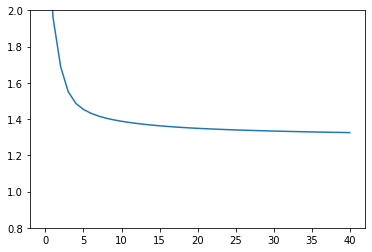

In [56]:
plt.plot(losses)
plt.ylim(0.8,2)

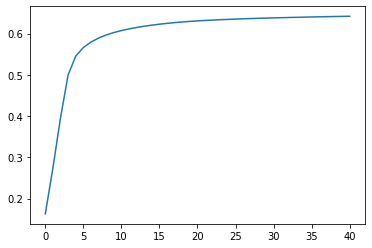

In [57]:
plt.plot(corrs)

In [58]:
d = data.to(device=device)
output = model(d)

In [59]:
cl = (data.x_cluster_labels == 0) & (data.batch == 0)

In [60]:
data.x[cl]

tensor([[11.0000,  0.5747, -0.9150, -0.2182,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 5.0000,  1.4826, -0.8153, -0.1475,  0.0000,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [61]:
data.y[cl]

tensor([[ 1.5058, -0.8316, -0.1477],
        [ 0.0000,  0.0000,  0.0000]], device='cuda:0')

In [62]:
output[cl]

tensor([[ 2.9972, -1.1011, -0.1670],
        [ 1.4066, -0.8759, -0.0798]], device='cuda:0', grad_fn=<IndexBackward>)

(0, 5)

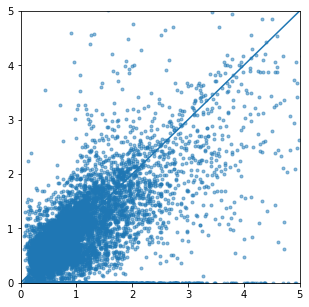

In [63]:
plt.figure(figsize=(5,5))
msk = data.y[:, 0] != 0
plt.scatter(
    data.y[msk][:, 0].detach().cpu().numpy(),
    output[msk][:, 0].detach().cpu().numpy(),
    marker=".", alpha=0.5)
plt.plot([0,5],[0,5])
plt.xlim(0,5)
plt.ylim(0,5)

(-5, 5)

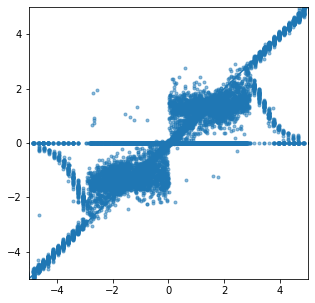

In [64]:
plt.figure(figsize=(5,5))
plt.scatter(
    data.y[msk, 1].detach().cpu().numpy(),
    output[msk, 1].detach().cpu().numpy(),
    marker=".", alpha=0.5)
plt.plot([-5,5],[-5,5])
plt.xlim(-5,5)
plt.ylim(-5,5)

(-5, 5)

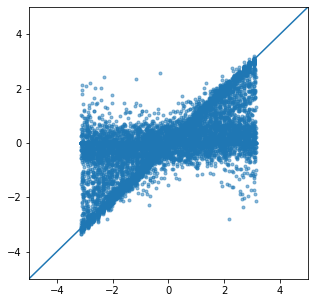

In [65]:
plt.figure(figsize=(5,5))
plt.scatter(
    data.y[msk, 2].detach().cpu().numpy(),
    output[msk, 2].detach().cpu().numpy(),
    marker=".", alpha=0.5)
plt.plot([-5,5],[-5,5])
plt.xlim(-5,5)
plt.ylim(-5,5)

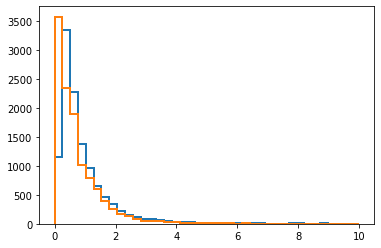

In [66]:
b = np.linspace(0,10,40)
plt.hist(data.y[msk, 0].detach().cpu().numpy(), bins=b, lw=2, histtype="step");
plt.hist(output[msk, 0].detach().cpu().numpy(), bins=b, lw=2, histtype="step");

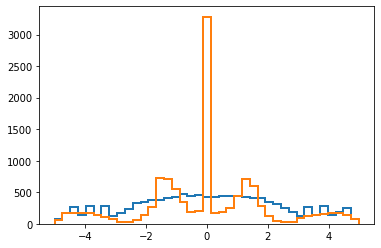

In [67]:
b = np.linspace(-5,5,40)
plt.hist(data.y[msk, 1].detach().cpu().numpy(), bins=b, lw=2, histtype="step");
plt.hist(output[msk, 1].detach().cpu().numpy(), bins=b, lw=2, histtype="step");

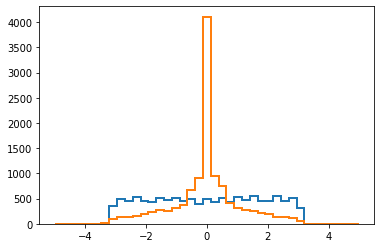

In [68]:
b = np.linspace(-5,5,40)
plt.hist(data.y[msk, 2].detach().cpu().numpy(), bins=b, lw=2, histtype="step");
plt.hist(output[msk, 2].detach().cpu().numpy(), bins=b, lw=2, histtype="step");